### Imports

In [59]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import constants, utils
import numpy as np
import json

from langchain_openai import ChatOpenAI
from langgraph.constants import Send
from langchain_core.messages import HumanMessage, SystemMessage

os.environ["OPENAI_API_KEY"] = utils.get_openai_api_key()
os.environ["TAVILY_API_KEY"] = utils.get_tavily_api_key()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Agents

#### Summarizer Agent

In [60]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.pydantic_v1 import BaseModel, Field

class Response(BaseModel):
    """Response to user."""

    response: str


system_template = """You are an expert summarizer. You are an agent working in summarizing a single chapter in a book, 
    which will then be used to create a summary of the entire book. You are tasked with summarizing the chapter."""
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}\n Summary:")]
)

text = """
1 Set the Table
There is one quality which one must possess to win, and that is definiteness of purpose, the knowledge of what one wants and a burning desire to achieve it.
NAPOLEON HILL
Before you can determine your “frog” and get on with the job of eating it, you have to decide exactly what you want to achieve in each area of your life. Clarity is perhaps the most important concept in personal productivity. The number one reason why some people get more work done faster is because they are absolutely clear about their goals and objectives, and they don’t deviate from them. The greater clarity you have regarding what you want and the steps you will have to take to achieve it, the easier it will be for you to overcome procrastination, eat your frog, and complete the task before you.
A major reason for procrastination and lack of motivation is vagueness, confusion, and fuzzy-mindedness about what you are trying to do and in what order and for what reason. 
"""
llm = ChatOpenAI(model=constants.MODEL_NAME).with_structured_output(Response)
summarizer = prompt_template | llm
# summarizer.invoke({"text": text})

#### Relevant Chapter Selection Agent

In [61]:
from langchain import hub
from langchain_openai import ChatOpenAI
from typing import Annotated, List, Tuple, TypedDict

from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.pydantic_v1 import BaseModel, Field

class ChapterList(BaseModel):
    """Response to user."""

    chapter_list: List[str]


system_template = "You are an agent helping to summarize a book parsed from an epub. The first step is to select the chapters which are relevant to summarize"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "Select the chapters which are relevant to summarize: {chapter_list}")]
)

llm = ChatOpenAI(model=constants.MODEL_NAME).with_structured_output(ChapterList)
chapter_selector_agent = prompt_template | llm

chapters = [
    "Cover",
    "Title",
    "Copyright",
    "Dedication",
    "Contents",
    "Preface",
    "Introduction: Eat That Frog",
    "1 Set the Table",
    "2 Plan Every Day in Advance",
    "3 Apply the 80/20 Rule to Everything",
    "4 Consider the Consequences",
    "5 Practice Creative Procrastination",
    "6 Use the ABCDE Method Continually",
    "7 Focus on Key Result Areas",
    "8 Apply the Law of Three",
    "9 Prepare Thoroughly Before You Begin",
    "10 Take It One Oil Barrel at a Time",
    "11 Upgrade Your Key Skills",
    "12 Identify Your Key Constraints",
    "13 Put the Pressure on Yourself",
    "14 Motivate Yourself into Action",
    "15 Technology Is a Terrible Master",
    "16 Technology Is a Wonderful Servant",
    "17 Focus Your Attention",
    "18 Slice and Dice the Task",
    "19 Create Large Chunks of Time",
    "20 Develop a Sense of Urgency",
    "21 Single Handle Every Task",
    "Conclusion: Putting It All Together",
    "Notes",
    "Index",
    "Learning Resources",
    "About"
]

# chapter_selector_agent.invoke({"chapter_list": chapters})

#### Summaries Aggregator Agent

In [62]:
system_template = """You are an expert summarizer. You are working with other summarizers to summarize a complete book.   
    Other summarizers have already summarized their respective chapters. You are now tasked with summarizing the entire 
    book based on the summaries provided by the other summarizers. The summary should be detailed and cover all the
    important points from each chapter. It should be around 6 paragraphs long."""
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "Chapter Summaries: \n" + "{text} \n---\n Complete book summary:")]
)

chapter_summaries = "Chapter 1: This chapter is about setting the table.\nChapter 2: This chapter is about planning every day in advance.\nChapter 3: This chapter is about applying the 80/20 rule to everything"

llm = ChatOpenAI(model=constants.MODEL_NAME).with_structured_output(Response)
summaries_aggreagator = prompt_template | llm
summaries_aggreagator.invoke({"text": chapter_summaries})

Response(response='The book emphasizes the importance of effective time management and productivity. In Chapter 1, the focus is on setting the table, which likely refers to setting the foundation for success. Chapter 2 delves into the significance of planning each day in advance to increase efficiency. Chapter 3 introduces the concept of the 80/20 rule, suggesting that prioritizing tasks based on their significance can lead to better outcomes. Together, these chapters highlight key strategies for optimizing time and achieving success.')

#### Refiner Agent

In [63]:
system_template = """You are an expert summarizer. You are working with other summarizers to summarize a complete book.   
    Other summarizers have already summarized their respective chapters. Another agent has created a complete book summary based on the summaries 
    of the chapters of the books. You are now tasked with refining the final summary by including any missing details and ensuring that the summary is
    coherent and well-structured. It should be around 6 paragraphs long."""
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "Chapter Summaries: \n" + "{chapter_summaries} \n---\n Complete book summary to refine: \n{complete_summary}\n---\nRefined summary:")]
)

chapter_summaries = "Chapter 1: This chapter is about setting the table.\nChapter 2: This chapter is about planning every day in advance.\nChapter 3: This chapter is about applying the 80/20 rule to everything"

llm = ChatOpenAI(model=constants.MODEL_NAME).with_structured_output(Response)
refiner = prompt_template | llm
#refiner.invoke({"text": chapter_summaries})

### Defining the State

In [64]:
import operator
from typing import Annotated, List, Tuple, TypedDict, Optional
from epub_parser import EPUB, ContentNode, Metadata
from dataclasses import dataclass


@dataclass
class ChapterSummary():
    chapter: ContentNode # Chapter Object 
    chapter_summary: str # Summary of the chapter

class BookSummarizerState(BaseModel):
    verbose: int  # Verbosity level: 0 (silent), 1 (verbose)
    book_name: Annotated[str, Field(description="Name of the book")]  # Name of the book
    book_dir: str  # Directory of the book
    book: Optional[EPUB] = None  # EPUB object
    chapter_titles_all: List[str] = []  # List of all chapter titles
    chapter_titles_to_summarize: List[str] = []  # List of chapter titles to summarize
    chapters_to_summarize: List[ContentNode] = []  # List of the chapters to summarize
    num_chapters_to_summarize: int  # Number of chapters to summarize
    chapter_summaries: Annotated[List[ChapterSummary], operator.add] = []  # List of summaries of the chapters
    final_summary: str = ""  # Final summary of the book

    class Config:
        arbitrary_types_allowed = True  # Allow arbitrary types such as EPUB

class BookSummarizerStateSummarizerAgent(TypedDict):
    index_chapter_to_summarize: int # Index of the chapter to summarize
    book_summarizer_state: BookSummarizerState # State of the book summarizer


### Functions for the Graph

In [65]:
from typing import Literal

def load_epub(state: BookSummarizerState):
    print("State: ", state, "\n SAVING SUMMARY") if state.get("verbose") == 1 else None
    book = EPUB(state.get("book_dir"))
    
    chapter_titles_all = []
    for node in book.root_node.children:
        chapter_titles_all.append(node.title)
    
    state.book = book
    state["chapter_titles_all"] = chapter_titles_all

    print("\n\n "+str(len(chapter_titles_all))+" chapters found in the book") 

    if state["num_chapters_to_summarize"] is None:
        state["num_chapters_to_summarize"] = len(chapter_titles_all)

    return state

def select_chapters_to_summarize(state: BookSummarizerState):
    print("State: ", state, "\n SELECTING CHAPTERS") if state.get("verbose") == 1 else None
    
    chapters = state.get("chapter_titles_all")
    chapter_titles_to_summarize = chapter_selector_agent.invoke({"chapter_list": chapters})
    state["chapter_titles_to_summarize"] = chapter_titles_to_summarize.chapter_list
    
    return state

def load_selected_chapters(state: BookSummarizerState):
    print("State: ", state, "\n LOADING SELECTED CHAPTERS") if state.get("verbose") == 1 else None
    chapter_titles_to_summarize = state.get("chapter_titles_to_summarize")
    book = state.get("book")
    chapter_contents = []
    num_chapters_to_summarize = state.get("num_chapters_to_summarize")

    num_chapters = 0
    for node in book.root_node.children:
        if num_chapters < num_chapters_to_summarize:
            if node.title in chapter_titles_to_summarize:
                chapter_contents.append(node)
                num_chapters += 1
        else:
            break
    state["chapters_to_summarize"] = chapter_contents
    return state

def send_to_summarizer_agents(state: BookSummarizerState):
    # We will return a list of `Send` objects. Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("summarizer_agent", {"index_chapter_to_summarize": i, "book_summarizer_state": state}) for i in range(len(state["chapters_to_summarize"]))]

async def summarize_chapter(state: BookSummarizerStateSummarizerAgent):
    print("State: ", state, "\n SUMMARIZING CHAPTER ", str(state["index_chapter_to_summarize"])) if state.get("verbose") == 1 else None
    
    # Obtain the chapter to summarize and summarize it with the summarizer agent
    index_chapter_to_summarize = state["index_chapter_to_summarize"]
    chapter_to_summarize = state["book_summarizer_state"]["chapters_to_summarize"][index_chapter_to_summarize]
    text = "Titlte of the Chapter: " + chapter_to_summarize.title + "\nContent: \n" + chapter_to_summarize.content
    agent_response = await summarizer.ainvoke({"text": text})
    summary = agent_response.response
    chapter_summary = ChapterSummary(chapter=chapter_to_summarize, chapter_summary=summary)
    
    print("\n\nFINAL SUMMARY: \n\n", agent_response.response) if state.get("verbose") == 1 else None
    return {"chapter_summaries": [chapter_summary]}

async def summaries_aggregator_agent(state: BookSummarizerState):
    print("State: ", state, "\n AGGREGATING CHAPTERS") if state.get("verbose") == 1 else None

    # Construct the string to submit to the summaries aggregator agent
    chapter_summaries = ""
    for chapter_summary in state["chapter_summaries"]:
        chapter_summaries += "Chapter: " + chapter_summary.chapter.title + "\nSummary: " + chapter_summary.chapter_summary + "\n\n"
    
    # Summarize the complete book
    agent_response = await summaries_aggreagator.ainvoke({"text": chapter_summaries})
    state["final_summary"] = agent_response.response

    print("\n\nFINAL SUMMARY: \n\n", agent_response.response) if state.get("verbose") == 1 else None
    return state

async def refiner_agent(state: BookSummarizerState):
    print("State: ", state, "\n AGGREGATING CHAPTERS") if state.get("verbose") == 1 else None

    # Construct the string to submit to the summaries aggregator agent
    chapter_summaries = ""
    for chapter_summary in state["chapter_summaries"]:
        chapter_summaries += "Chapter: " + chapter_summary.chapter.title + "\nSummary: " + chapter_summary.chapter_summary + "\n\n"
    
    final_summary = state.get("final_summary")

    agent_response = await refiner.ainvoke({"chapter_summaries": chapter_summaries, "complete_summary": final_summary})
    state["final_summary"] = agent_response.response

    print("\n\nREFINED FINAL SUMMARY: \n\n", agent_response.response) if state.get("verbose") == 1 else None
    return state

def show_results(state: BookSummarizerState):
    print("State: ", state, "\n SHOWING RESULTS") if state.get("verbose") == 1 else None
    for i, response in enumerate(state.get("chapter_summaries")):
        print("Chapter: ", response.chapter.title)
        print("Summary: ", response.chapter_summary)
        print("\n\n")
    
    # Save the final summary to a json file
    file_name = state.get("book_name").replace(" ", "_") + "--"+constants.MODEL_NAME+"--summary.json"
        # The content should be a dictionary with the epub file name as the key and the final summary as the value
    content = {state.get("book_name").replace(" ", "_"): state.get("final_summary")}
    # Save the dictionary to a JSON file
    with open(file_name, 'w') as json_file:
        json.dump(content, json_file, indent=4)

    print("\n\nFinal Summary: ", state.get("final_summary"))

### Create the Graph

In [66]:
from langgraph.graph import StateGraph

graph = StateGraph(BookSummarizerState)

graph.add_node("load_epub", load_epub)
graph.add_node("select_chapters_to_summarize", select_chapters_to_summarize)
graph.add_node("load_selected_chapters", load_selected_chapters)
graph.add_node("send_to_summarizer_agents", send_to_summarizer_agents)
graph.add_node("summarizer_agent", summarize_chapter)
graph.add_node("summaries_aggregator_agent", summaries_aggregator_agent)
graph.add_node("refiner_agent", refiner_agent)
graph.add_node("show_results", show_results)


graph.set_entry_point("load_epub")

graph.add_edge("load_epub", "select_chapters_to_summarize")
graph.add_edge("select_chapters_to_summarize", "load_selected_chapters")
graph.add_conditional_edges("load_selected_chapters", send_to_summarizer_agents)
graph.add_edge("summarizer_agent", "summaries_aggregator_agent")
graph.add_edge("summaries_aggregator_agent", "refiner_agent")
graph.add_edge("refiner_agent", "show_results")
graph.add_edge("show_results", "__end__")

app = graph.compile()

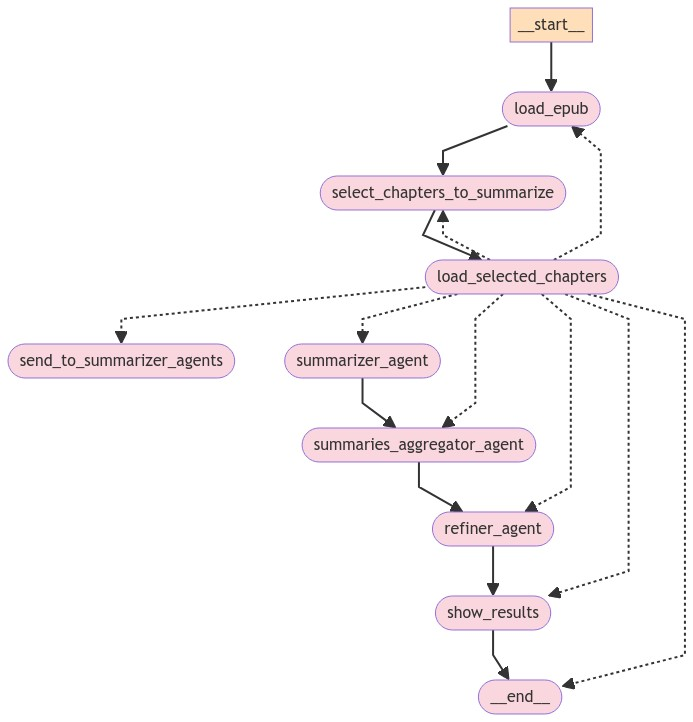

In [67]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### Execute the Graph


In [73]:
config = {"recursion_limit": 50}
# book_name = "Eat that Frog!"
book_name = "reminiscences-of-pioneer-days-in-st-paul"
# book_dir = constants.BOOKS_DIR + 'eat_that_frog.epub'
book_dir = constants.BOOKS_DIR + 'reminiscences-of-pioneer-days-in-st-paul.epub'
num_chapters_to_summarize = 3
verbose = 0
inputs = {"book_name": book_name, "book_dir": book_dir, "num_chapters_to_summarize": num_chapters_to_summarize, "verbose": verbose}
# inputs = (book_name=book_name, book_dir= book_dir, num_chapters_to_summarize= num_chapters_to_summarize, verbose= verbose)
book_config = BookSummarizerState(**inputs)
print(book_config.dict())

async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print("Key:", k, "Value:", v)
            

{'verbose': 0, 'book_name': 'reminiscences-of-pioneer-days-in-st-paul', 'book_dir': '/home/pedro/Documents/GitHub/SwarmGPT/data/books/reminiscences-of-pioneer-days-in-st-paul.epub', 'book': None, 'chapter_titles_all': [], 'chapter_titles_to_summarize': [], 'chapters_to_summarize': [], 'num_chapters_to_summarize': 3, 'chapter_summaries': [], 'final_summary': ''}


ValidationError: 4 validation errors for BookSummarizerState
chapter_titles_all
  none is not an allowed value (type=type_error.none.not_allowed)
chapter_titles_to_summarize
  none is not an allowed value (type=type_error.none.not_allowed)
chapters_to_summarize
  none is not an allowed value (type=type_error.none.not_allowed)
final_summary
  none is not an allowed value (type=type_error.none.not_allowed)